import functions

In [1]:

import  os,warnings, sys, shutil, os, numpy as np, pandas as pd
# import pandas as pd


warnings.filterwarnings("ignore")
# import pickle
# import torch
from sklearn.metrics import  accuracy_score
path = os.path.dirname(os.getcwd())

data_path = path + '/.data/' 
sys.path.insert(0,data_path )
sys.path.insert(0,path + '/mutual_functions/' )


from evaluation_functions import *
from load_data import *
from normalization import *
from utils import *


# reload packages with new changes
%load_ext autoreload
%autoreload 2

# data_path
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
# torch.cuda.empty_cache()


import tensorflow as tf
import keras
# get the first available GPU if exists and allow TensorFlow to allocate memory on GPU dynamically
device = tf.config.list_physical_devices('GPU')[0] if len(tf.config.list_physical_devices('GPU'))>0 else tf.config.list_physical_devices('CPU')[0]
if 'GPU' in device.name: tf.config.experimental.set_memory_growth(device, True)
device = '/GPU:0' if 'GPU' in device.name else '/CPU:0'
print(device)




2023-10-23 17:37:08.120498: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 17:37:08.120557: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 17:37:08.120601: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-23 17:37:08.128620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 17:37:09.215286: W tensorflow/compiler/

/CPU:0


In [6]:

prop = {'UCR':True,
        'dataset':'BasicMotions', #'shortTracks_seperate.pkl,LSST,AF,BasicMotions
        'data_path' : data_path,
        
        'norm':'without_norm', #'MinMax01',MinMax-11 # 'mean_standardize', 'without_norm'
        'seq_len':20,#20, 
        'LEN':None, #None,#7
        'consecutive': True,
        'val_size':0,
        'size_percentage' : None,

        'shuffle': False,
        'test_size' :0.2,
       
        'multivariate':True,

        'model': 'InceptionTime', #'InceptionTime','FCN','CNN','LSTMFCN', 'MLP','TapNet','MACNN','MCDCNN','ResNet' , 'SimpleRNN']#
        # deep learning model:
        # MCDCNN (Multi Channel Deep Convolutional Neural Network)
        # MACNN (Multi Attention Convolutional Neural Network)
        # TapNet (Temporal Attention and Gating Network)
        # LSTMFCN (LSTM Fully Convolutional Network)
        # FCN (Fully Convolutional Network)
        # CNN (Convolutional Neural Network)
        # InceptionTime (InceptionTime)
        # ResNet (ResNet)
        # SimpleRNN (SimpleRNN)
        # MLP (Multi Layer Perceptron)
        'params':{
                'verbose':False,
                'n_epochs': 0,#2000,
                'random_state':None, #Seed for random number generation.
                'batch_size':16, #int, default = 16;the number of samples per gradient update.
                'metrics':'CategoricalAccuracy', #list of strings, default=[“accuracy”]
                # loss - rest:categorical_crossentropy,CNN:mean_squared_error,TapNetClassifier: binary_crossentropy
                'loss':'mean_squared_error',# string with default value for each model
        
                # 'optimizer':keras.optimizers.Adam(learning_rate=0.01)#LSTMFCNClassifier,InceptionTimeClassifier #keras.optimizers object, default = Adam(lr=0.01)
                # Activation function used in the output linear layer. List of available activation functions: https://keras.io/api/layers/activations/
                # all models with sigmoid which is for classification probability
                },

}
# 'InceptionTime','FCN','CNN','LSTMFCN', 'MLP','TapNet','MACNN','MCDCNN','ResNet' , 'SimpleRNN'
# if model['model'] ==  'CNN':
# class CNNClassifier( kernel_size=7, avg_pool_size=3, n_conv_layers=2, loss='mean_squared_error',  use_bias=True, 
# # FCNClassifier
# loss='categorical_crossentropy',  use_bias=True, 
# # LSTMFCNClassifier
# batch_size=128, dropout=0.8, kernel_sizes=(8, 5, 3), filter_sizes=(128, 256, 128), lstm_size=8, attention=False, 
# # InceptionTimeClassifier
# batch_size=64, kernel_size=40, n_filters=32, use_residual=True, use_bottleneck=True, bottleneck_size=32, depth=6,  loss='categorical_crossentropy'
# # MLPClassifier
# loss='categorical_crossentropy' use_bias=True, 
# # TapNetClassifier
# dropout=0.5, filter_sizes=(256, 256, 128), kernel_size=(8, 5, 3), dilation=1, layers=(500, 300), use_rp=True, rp_params=(-1, 3), use_bias=True, use_att=True, use_lstm=True, use_cnn=True,  padding='same', loss='binary_crossentropy', 

In [7]:


X_train,y_train,X_test,y_test,X_val,y_val,prop = loadData(prop,prop['data_path'])
X_train, X_test, X_val = normalizeData(X_train,X_test,X_val,norm  = prop['norm'])
X_train,X_test, X_val = convert_into_sktime(X_train),convert_into_sktime(X_test),convert_into_sktime(X_val)


Data loading start...
seq_len (n steps): 20, data columns: ['dim_0', 'dim_1', 'dim_2', 'dim_3', 'dim_4', 'dim_5']
train - 0: 810, test - 0: 810
train - 1: 810, test - 1: 810
train - 2: 810, test - 2: 810
train - 3: 810, test - 3: 810
preprocessing data using 'without_norm' complete...
X_train: (3240, 20, 6), X_test: (3240, 20, 6), X_val: None


deep_learning classification models; initaiate and train

In [8]:
# for m in 'InceptionTime','FCN','CNN','LSTMFCN', 'MLP','TapNet','MACNN','MCDCNN','ResNet' , 'SimpleRNN':
# initiate model using pc device
with tf.device(device): 
   model = dl_model(model_type = prop['model'],params = prop['params'].copy())
   # model.metrics = 'CategoricalCrossentropy'


# train model (fit)
print(model)
print('model:', model.fit(X_train, y_train))
model.summary()
y_test_pred = predict_dl( X_test, y_test,model)



#  model.save('model.h5')

{'verbose': False, 'random_state': None, 'batch_size': 16} , metrics:  CategoricalAccuracy , loss:  mean_squared_error
InceptionTimeClassifier(batch_size=16, loss='mean_squared_error',
                        metrics='CategoricalAccuracy', n_epochs=0)
model: InceptionTimeClassifier(batch_size=16, loss='mean_squared_error',
                        metrics='CategoricalAccuracy', n_epochs=0)
203/203 [==============================] - 2s 6ms/step
Test accuracy score of InceptionTimeClassifier(n_epochs=0) is 0.0941358024691358


sklearn's GridSearchCV

In [ ]:
# # cnn
# param_grid = {"kernel_size": [7, 9], "avg_pool_size": [3, 5]}
# grid = GridSearchCV(network, param_grid=param_grid, cv=3)
# # grid.fit(X_train, y_train)

# # inception time
# param_grid = {"nb_filters": [16, 32], "bottleneck_size": [16, 32]}
# grid = GridSearchCV(network, param_grid=param_grid, cv=5)
# # commented fit call to pass checks (meet time constraints)
# # grid.fit(X_train, y_train)

# # print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
# # print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
# # print("Best parameters: {}".format(grid.best_params_))

inference & analysis
1. prediction of test data
2. returns test_metrics: for classification [loss, acc, prec, rec, f1] else [rmse, mae]

roc curve applicable only for binary classification (this is a multiclass classification)


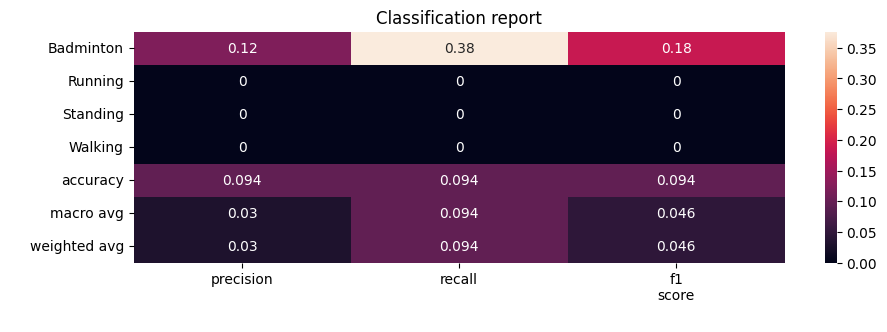

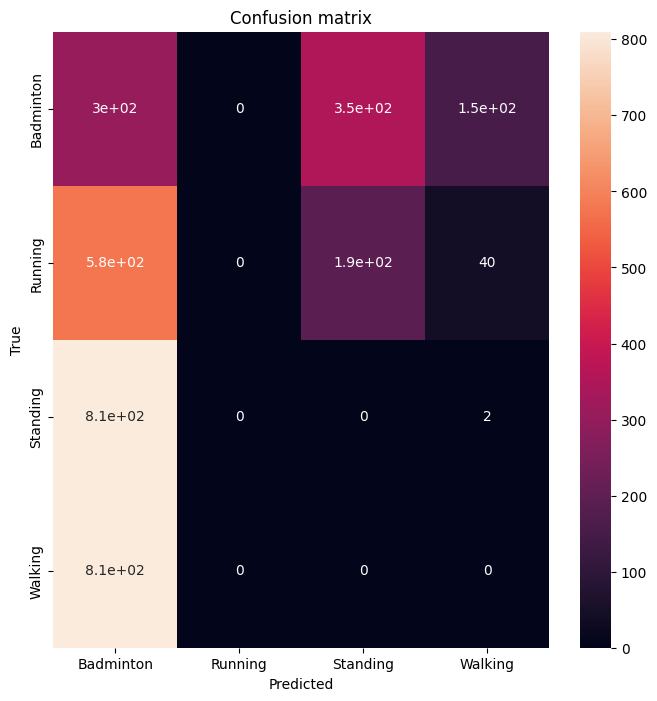

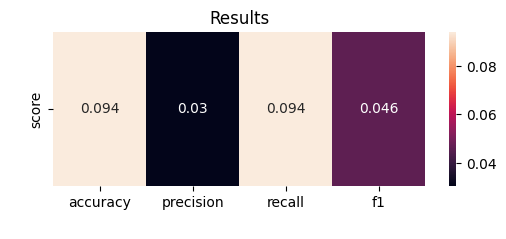

In [11]:



prop['class_names'],prop['class_transform'] = get_class_names(df=pd.read_csv(data_path + prop['dataset'] + '/class.csv', index_col=None),
                                                               class_to_consecutive = prop['class_to_consecutive'].copy(),type_ = 'type')

evaluate_(y_test_pred, y_test, prop['nclasses'],  class_names = prop['class_names'],class_transform = prop['class_transform'],
          model_name=prop['model'] )
